# Testing File
---
_This notebook is for testing new functionality before introducing it into the program._

### Protocol
---
_Pokémon Showdown is accessible via websockets, so I can interact with the website from this file (sending messages, logging in, and so on)._
_Found here: https://github.com/smogon/pokemon-showdown/blob/master/PROTOCOL.md_

_This has been done before in python here: https://github.com/pmariglia/showdown/blob/master/showdown/websocket_client.py_

**Variables I'll need**:
* Websocket UI
* Username and Password
* Format
* Team to use (if applicable)

In [ ]:
import asyncio
import websockets
import requests
import json
import random

In [ ]:
state = {} # update state every turn
outputs = [] # add output to this list every turn

In [ ]:
# Open previously scraped data and load into memory.
with open('data/sample-state.json') as f:
    state = json.load(f)
with open('data/abilitydata.json') as f:
    abilityData = json.load(f)
with open('data/movedata.json') as f:
    moveData = json.load(f)
with open('data/pokedata.json') as f:
    pokeData = json.load(f)
with open('data/dictionary.json') as f:
    miscData = json.load(f)
with open('data/itemdata.json') as f:
    itemData = json.load(f)

In [ ]:
# Very simple function for compiling a JSON of every move for later use.
def getMoveData():
    moveData = {}
    for i in range(919):
        data = requests.get("https://pokeapi.co/api/v2/move/"+(str)(i+1)).json()

        # Category needs to be translated from string into a number, like this.
        category = 0
        match data["damage_class"]["name"]:
            case "physical":
                category = 1
            case "special":
                category = 2
            case "status":
                category = 0

        # Don't allow Nones & replace -s with nothing, so the formatting matches showdown.
        power = 0 if data["power"] is None else data["power"]
        name = data["name"].replace("-", "")

        newMove = {"id": data["id"], "category": category, "power": power, "type": types[data["type"]["name"]]}
        moveData[name] = newMove

    with open("movedata.json", "w") as f:
        json.dump(moveData, f, ensure_ascii=False, indent=4)

In [ ]:
# Similar function for compiling a JSON of every pokémon's ID, types, and base speed.
# This is all of the unknown data that showdown does not send us.
def getPokeData():
    pokeData = {}
    for i in range(1024):
        data = requests.get("https://pokeapi.co/api/v2/pokemon/"+(str)(i+1)).json()
        name = data["name"].replace("-", "")
        
        # While this may seem kind of inefficient, a lot of pokemon projects internally consider
        # single-typed pokemon to be dual-typed with the same type.
        if len(data["types"]) > 1:
            newPoke = {"id": data["id"], "type1": types[data["types"][0]["type"]["name"]], "type2": types[data["types"][1]["type"]["name"]], "baseSpeed": data["stats"][5]["base_stat"]}
        else:
            newPoke = {"id": data["id"], "type1": types[data["types"][0]["type"]["name"]], "type2": types[data["types"][0]["type"]["name"]], "baseSpeed": data["stats"][5]["base_stat"]}
        pokeData[name] = newPoke

    with open("pokedata.json", "w") as f:
        json.dump(pokeData, f, ensure_ascii=False, indent=4)

In [ ]:
# (Hopefully) Final function for data scraping, this one just gets abilities and gives them an ID.
def getAbilities():
    abilities = {}
    for i in range(307):
        data = requests.get("https://pokeapi.co/api/v2/ability/"+(str)(i+1)).json()
        name = data["name"].replace("-", "")
        abilities[name] = data["id"]

    with open("abilitydata.json", "w") as f:
        json.dump(abilities, f, ensure_ascii=False, indent=4)

In [ ]:
# Forgot items :(
def getItems():
    items = {}
    # These are the item categories that are held items.
    # Thank you PokeAPI, for making me go through all those manually :( 
    for category in [3, 4, 5, 6, 11, 12, 14, 16, 18]:
        heldItems = requests.get("https://pokeapi.co/api/v2/item-category/"+(str)(category)).json()
        for item in heldItems["items"]:
            data = requests.get(item["url"]).json()
            name = data["name"].replace("-", "")
            items[name] = len(items)+1

    with open("itemdata.json", "w") as f:
        json.dump(items, f, ensure_ascii=False, indent=4)

In [ ]:
def updateState(newState):
    # Extract information from newState
    porySide = newState["side"]["pokemon"]
    activeMoves = newState["active"]["moves"]
    
    for poke in range(len(porySide)):
        pokeName = porySide[poke]["details"].split(",")[0].replace("-", "").lower()
        pokeHp = eval(porySide[poke]["condition"].split(" ")[0])
        pokeStatus = porySide[poke]["condition"].split(" ")[1] if len(porySide[poke]["condition"].split(" ")) > 1 else "none"
        pokeAbility = porySide[poke]["ability"]
        pokeMoves = porySide[poke]["moves"]
        pokeStats = porySide[poke]["stats"]
        pokeItem = porySide[poke]["item"]
        pokeTeraType = porySide[poke]["teraType"]
        pokeTerrastillized = 0 if not porySide[poke]["terrastillized"] else 1

        if poke == 0: # The first mon in the array is always the active one.
                        # Pokemon type, id, stats fetched from pokedata
            state["playerSide"]["activeMon"]["id"] = pokeData[pokeName]["id"]
            state["playerSide"]["activeMon"]["stats"]["baseSpeed"] = pokeData[pokeName]["baseSpeed"]
            state["playerSide"]["activeMon"]["type1"] = pokeData[pokeName]["type1"]
            state["playerSide"]["activeMon"]["type2"] = pokeData[pokeName]["type2"]

            # Condition and TeraType from showdown.
            state["playerSide"]["activeMon"]["condition"]["hp"] = pokeHp
            state["playerSide"]["activeMon"]["condition"]["status"] = miscData["conditions"][pokeStatus]
            state["playerSide"]["activeMon"]["teraType"] = miscData["types"][pokeTeraType]
            state["playerSide"]["activeMon"]["terrastillized"] = pokeTerrastillized

            # Ability and item fetched from abilityData and itemData
            state["playerSide"]["activeMon"]["ability"] = abilityData[pokeAbility]
            state["playerSide"]["activeMon"]["item"] = itemData[pokeItem]

            for move in range(len(pokeMoves)): # Moves fetched from moveData
                state["playerSide"]["activeMon"]["moves"][move] = moveData[pokeMoves[move]]
                state["playerSide"]["activeMon"]["moves"][move]["pp"] = activeMoves[move]["pp"]
                state["playerSide"]["activeMon"]["moves"][move]["disabled"] = 0 if not activeMoves[move]["disabled"] else 1
            for stat in pokeStats.keys():
                state["playerSide"]["activeMon"]["stats"][stat] = pokeStats[stat]
        else:
            # Pokemon type, id, stats fetched from pokedata
            state["playerSide"]["reserves"][poke-1]["id"] = pokeData[pokeName]["id"]
            state["playerSide"]["reserves"][poke-1]["stats"]["baseSpeed"] = pokeData[pokeName]["baseSpeed"]
            state["playerSide"]["reserves"][poke-1]["type1"] = pokeData[pokeName]["type1"]
            state["playerSide"]["reserves"][poke-1]["type2"] = pokeData[pokeName]["type2"]

            # Condition and TeraType from showdown.
            state["playerSide"]["reserves"][poke-1]["condition"]["hp"] = pokeHp
            state["playerSide"]["reserves"][poke-1]["condition"]["status"] = miscData["conditions"][pokeStatus]
            state["playerSide"]["reserves"][poke-1]["teraType"] = miscData["types"][pokeTeraType]
            state["playerSide"]["reserves"][poke-1]["terrastillized"] = pokeTerrastillized

            # Ability and item fetched from abilityData and itemData
            state["playerSide"]["reserves"][poke-1]["ability"] = abilityData[pokeAbility]
            state["playerSide"]["reserves"][poke-1]["item"] = itemData[pokeItem]

            for move in range(len(pokeMoves)): # Moves fetched from moveData
                state["playerSide"]["reserves"][poke-1]["moves"][move] = moveData[pokeMoves[move]]
            for stat in pokeStats.keys():
                state["playerSide"]["reserves"][poke-1]["stats"][stat] = pokeStats[stat]
        
    print(state)

In [ ]:
# Global used for sending and receiving messages.
socket = await websockets.connect("wss://sim3.psim.us/showdown/websocket")

# Connect to the Showdown server and log in.
async def connectToShowdown(loginUri, testUsername, testPassword):
    # challstr and chall id represent the current user token.
    # we need to retrieve it from the showdown server. When not logged in,
    # the server will send the user their challstr and challid whcih we receive below.
    challid = 0
    challstr = ""

    while(challstr == ""):
        received = await socket.recv()
        msgs = received.split("|")
        if(msgs[1] == "challstr"):
            challid = msgs[2]
            challstr = msgs[3]

    challstr = "|".join([challid, challstr]) # Join these together to form the token to be sent to the server

    # HTTP Request 
    loggedIn = requests.post(
        loginUri,
        data={
            "act": "login",
            "name": testUsername,
            "pass": testPassword,
            "challstr": challstr,
        }
    )

    # Finish logging in by grabbing the "assertion" given to us by showdown in JSON.
    jsonOut = json.loads(loggedIn.text[1:])
    await sendMessage("|/trn "+testUsername+",0,"+jsonOut["assertion"]+"|")

async def sendMessage(message):
    await socket.send([message])
    return await socket.recv()


# Join the queue by sending a search message in a specific format.
# Returns a battle tag, used by other methods to specify what battle room to interact with.
async def joinQueue(format):
    received = await sendMessage("|/search "+format+"|")

    while True:
        received = received.split("|")
        if 'battle' in received[0]:
            return received[0][1:].strip()
        received = await socket.recv()


# Runs the battle logic. When the Model is implemented, will instead make calls to the model for what to do.
# Should also send it the necessary battle info.
async def manageBattle(battle_tag):
    while True:
        received = await socket.recv()
        print(received)
        msgs = received.split("|")

        # Check for a battle
        if 'request' in msgs[1] and len(msgs[2]) > 9:

            requestOutput = json.loads(msgs[2])
            updateState(requestOutput)

            # Make a move
            if 'active' in requestOutput:
                invalidMove = True

                # Pokémon can be locked into moves, so we need to check that the chosen move hasn't been disabled.
                while invalidMove:
                    randomMove = random.choice(requestOutput["active"][0]["moves"])
                    if not randomMove["disabled"]:
                        invalidMove = False
                        await socket.send(battle_tag+'|/choose move '+randomMove["id"]+"|"+str(requestOutput["rqid"]))

            # Mon has fainted - make a switch.
            if 'forceSwitch' in requestOutput:
                invalidMon = True
            
                while invalidMon:
                    randomMon = random.randint(0,5)
                    print(requestOutput["side"]["pokemon"][randomMon])
                    print(requestOutput["side"]["pokemon"][randomMon]["condition"])
                    # Don't send in a fainted mon or try to send in the current one.
                    if(requestOutput["side"]["pokemon"][randomMon]["condition"] != "0 fnt") and (requestOutput["side"]["pokemon"][randomMon]["active"] == False):
                        invalidMon = False
                        await socket.send(battle_tag+'|/choose switch '+str(randomMon+1)+"|"+str(requestOutput["rqid"]))
        
        # Exit once a battle's over.
        if 'win' in msgs[1]:
            return

        

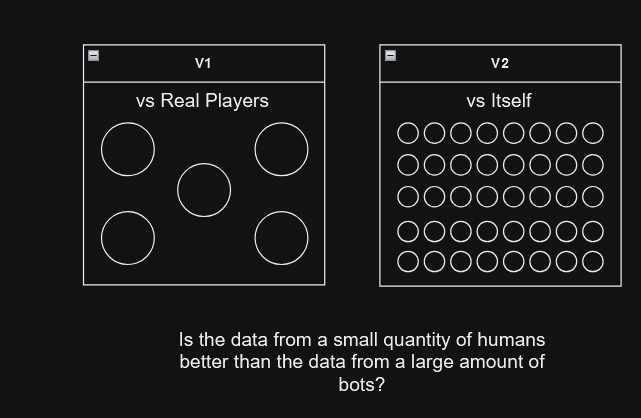

In [ ]:
await connectToShowdown("https://play.pokemonshowdown.com/action.php", "thisisatest12345", "password")
tag = await joinQueue("gen9randombattle")
await manageBattle(tag)

Currently struggling with setting up an environment for Pory AI to operate in.


Research:
https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf
https://www.tensorflow.org/agents/tutorials/6_reinforce_tutorial
https://github.com/lorenzenv/Neural-Network-Chess-Engine/blob/main/train.py
https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb
https://www.youtube.com/watch?v=DcYLT37ImBY < - somone trained a neural network to play the whole of pokemon red
* This was generally uninterested in the details of battling.
* Will check out their github for how they worked with the env, but it looks to be taking an image of the emulator.
* Overall useful, though a bit of the video is trying to anthropomorphise the model.
* Compares the AI buying a magikarp to humans buying junk food at one point.


During a game...
* Receive status every battle.
* Make a decision.
* After the turn completes, tally up the points for that turn and apply them.
* Every iteration should go for about 10 battles.
* Battles between bots should "time out" after 50 turns, resulting in no loss/win points.

From what I've read, I think I will have to start with training it on itself on a local clone of showdown, which I've gotten working on my PC.